In [17]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
wk = pd.read_excel('ucsb_workshops_list_addedAffiliation.xlsx', sheet_name='comp_wkshp_instr')
wk.shape

(92, 125)

In [19]:
# Remove UC workshops
wk = wk.loc[~wk['title_home'].str.contains('UC '), :]

# Remove workshop without dates
wk = wk.loc[wk['date']!='[]', :]

In [20]:
# Fix date without proper format
wk['date'] = wk['date'].str.replace('2022-11-8', '2022-11-08')
wk['month_day'] = wk['date'].str.replace('-', '').str[4:].astype(int)
wk['quarter'] = pd.cut(wk['month_day'],
                                 bins=[0, 331, 615, 915, 1231],
                                 labels=["Winter", "Spring", "Summer", "Fall"],
                                 include_lowest=True)

In [21]:
# From wide to long
df = pd.melt(wk.drop(columns='month_day'), id_vars=['date', 'title_home', 'quarter'], value_name='role', var_name='Name').dropna(subset='role')

In [22]:
df

,date,title_home,quarter,Name,role
176,2025-01-23,Working with Geospatial Data in R,Winter,Allie Caughman,instructor
290,2022-08-16,Machine Learning for Tabular Data in R,Summer,Amanda Ho,helper
291,2022-08-09,Intro to Geospatial Raster and Vector Data with R,Summer,Amanda Ho,helper
292,2022-07-26,Intro to Data Analysis and Visualization in R,Summer,Amanda Ho,instructor
293,2022-07-19,Version Control with Git,Summer,Amanda Ho,instructor
...,...,...,...,...,...
10403,2019-03-21,"Bash, Git & R",Winter,Yuan Wu,instructor
10404,2019-02-21,"Bash, Git & R",Winter,Yuan Wu,instructor
10405,2019-01-25,"Bash, Git & R",Winter,Yuan Wu,instructor
10480,2020-01-31,Databases and SQL,Winter,Zach Sisco,instructor


In [23]:
# Merge with list of instructors
inst = pd.read_excel('ucsb_workshops_list_addedAffiliation.xlsx', sheet_name='summary_instr')
df = df.merge(inst[['Name', 'Affiliation']], how='left', on='Name')

In [24]:
# Drop duplicates
df = df.drop_duplicates()

In [25]:
# Replace Jose from DREAM Lab to Other in 2024-02-27 and 2024-01-30
df.loc[((df['date']=='2024-02-27') | (df['date']=='2024-01-30')) & (df['Name']=='Jose Niño Muriel'), 'Affiliation'] = 'Other'

In [26]:
# Create column year
df['year'] = df['date'].str[:4].astype(int)

In [27]:
# Define academic year grouping
def get_academic_year(row):
    quarter, year = row['quarter'], row['year']
    if quarter in ['Fall']:
        return f"{year}-{year + 1}"
    else:
        return f"{year-1}-{year}"

df['academic-year'] = df.apply(get_academic_year, axis=1)

In [28]:
def sort_quarter_year(quarter_year):
    quarter, year = quarter_year.split()
    year = int(year)  # Convert year to integer
    quarter_order = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}  # Define quarter order
    return (year, quarter_order[quarter])  # Sort by year first, then quarter order

In [29]:
# Define the correct order of the quarters
quarter_order = ['Winter', 'Spring', 'Summer', 'Fall']

# Convert 'quarter' column to a categorical type with the defined order
df['quarter'] = pd.Categorical(df['quarter'], categories=quarter_order, ordered=True)

# Sort by 'year' and 'quarter' to ensure proper ordering
df = df.sort_values(['year', 'quarter'])

# Create a new 'quarter-year' column with the updated order
df['quarter-year'] = df['quarter'].astype(str) + ' ' + df['year'].astype(str)

In [43]:
df

,date,title_home,quarter,Name,role,Affiliation,year,academic-year,quarter-year
111,2019-03-21,"Bash, Git & R",Winter,Greg Janée,instructor,RDS,2019,2018-2019,Winter 2019
112,2019-02-21,"Bash, Git & R",Winter,Greg Janée,instructor,RDS,2019,2018-2019,Winter 2019
113,2019-01-25,"Bash, Git & R",Winter,Greg Janée,instructor,RDS,2019,2018-2019,Winter 2019
138,2019-03-21,"Bash, Git & R",Winter,Ian Lessing,instructor,Other Library,2019,2018-2019,Winter 2019
139,2019-02-21,"Bash, Git & R",Winter,Ian Lessing,instructor,Other Library,2019,2018-2019,Winter 2019
...,...,...,...,...,...,...,...,...,...
402,2025-01-14,Introduction to Data Analysis with Python,Winter,Seth Erickson,instructor,DREAM Lab,2025,2024-2025,Winter 2025
438,2025-02-18,Intermediate R,Winter,Sigrid Van Den Abbeele,instructor,Other,2025,2024-2025,Winter 2025
439,2025-01-23,Working with Geospatial Data in R,Winter,Sigrid Van Den Abbeele,instructor,Other,2025,2024-2025,Winter 2025
440,2025-01-14,Introduction to Data Analysis with Python,Winter,Sigrid Van Den Abbeele,helper,Other,2025,2024-2025,Winter 2025


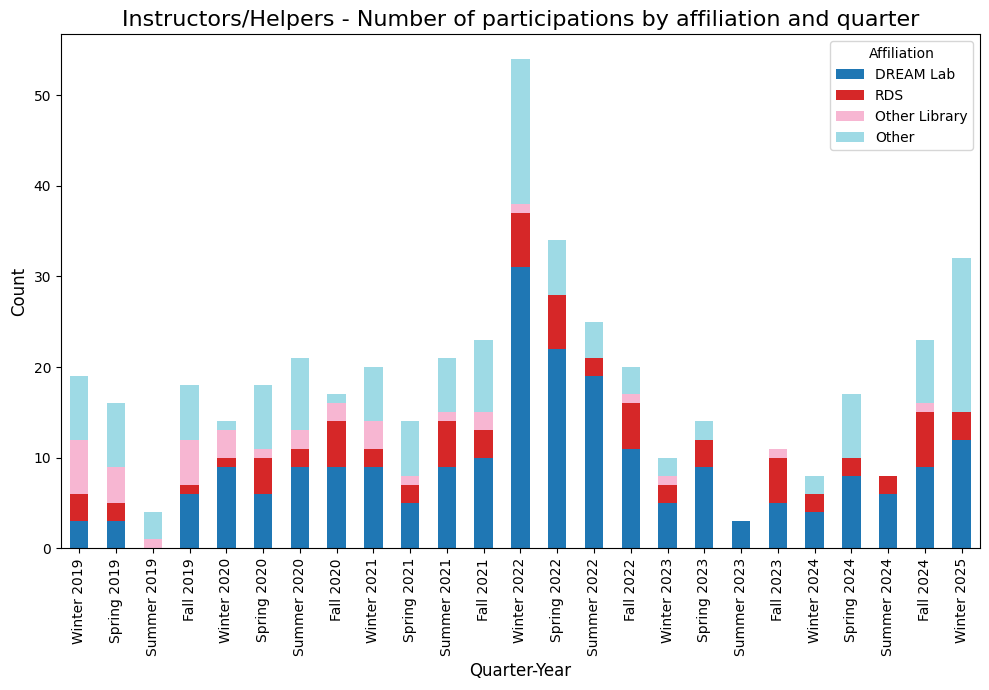

In [41]:
# Group by 'quarter-year' and 'Affiliation' and count occurrences
grouped = df.groupby(['quarter-year', 'Affiliation']).size().unstack(fill_value=0)

# Sort the index of the grouped DataFrame using the custom sort key
grouped = grouped.reindex(sorted(grouped.index, key=sort_quarter_year), axis=0)

# Reorder columns (Affiliation) in the desired order
desired_order = ['DREAM Lab', 'RDS', 'Other Library', 'Other']
grouped = grouped.reindex(columns=desired_order, fill_value=0)

# Plot the stacked bar plot
grouped.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')

# Add title, labels, and legend
plt.title('Instructors/Helpers - Number of participations by affiliation and quarter', fontsize=16)
plt.xlabel('Quarter-Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Affiliation')

# Display the plot
plt.tight_layout()
plt.savefig('plots/int_help_number_quarter.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
grouped

Affiliation,DREAM Lab,RDS,Other Library,Other
quarter-year,,,,
Winter 2019,3,3,6,7
Spring 2019,3,2,4,7
Summer 2019,0,0,1,3
Fall 2019,6,1,5,6
Winter 2020,9,1,3,1
Spring 2020,6,4,1,7
Summer 2020,9,2,2,8
Fall 2020,9,5,2,1
Winter 2021,9,2,3,6


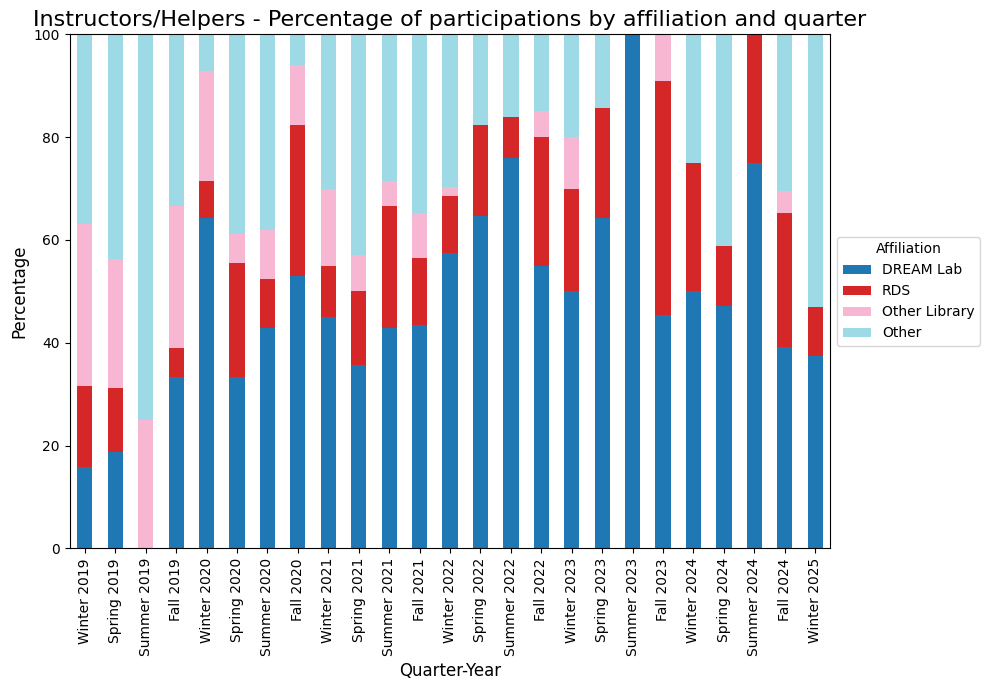

In [32]:
# Convert the counts to percentages (row-wise)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the stacked percentage bar plot
grouped_percent.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')

# Add title, labels, and legend
plt.title('Instructors/Helpers - Percentage of participations by affiliation and quarter', fontsize=16)
plt.xlabel('Quarter-Year', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Affiliation', loc='center left', bbox_to_anchor=(1, 0.5))

# Ensure the y-axis ranges from 0 to 100%
plt.ylim(0, 100)

# Display the plot
plt.tight_layout()
plt.savefig('plots/int_help_perc_quarter.png', dpi=300, bbox_inches='tight')
plt.show()

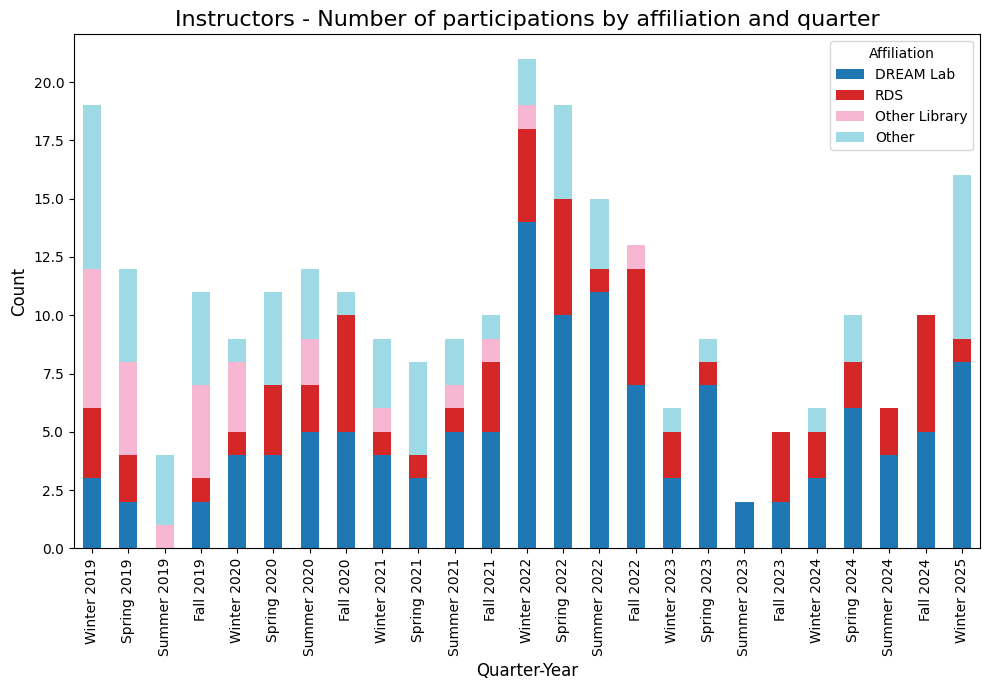

In [33]:
# Group by 'quarter-year' and 'Affiliation' and count occurrences
data = df[df['role'] == 'instructor']
grouped = data.groupby(['quarter-year', 'Affiliation']).size().unstack(fill_value=0)

# Ensure the x-axis is in the correct order
grouped = grouped.reindex(sorted(grouped.index, key=sort_quarter_year), axis=0)

# Reorder columns (Affiliation) in the desired order
desired_order = ['DREAM Lab', 'RDS', 'Other Library', 'Other']
grouped = grouped.reindex(columns=desired_order, fill_value=0)

# Plot the stacked bar plot
grouped.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')

# Add title, labels, and legend
plt.title('Instructors - Number of participations by affiliation and quarter', fontsize=16)
plt.xlabel('Quarter-Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Affiliation')

# Display the plot
plt.tight_layout()
plt.savefig('plots/int_number_quarter.png', dpi=300, bbox_inches='tight')
plt.show()

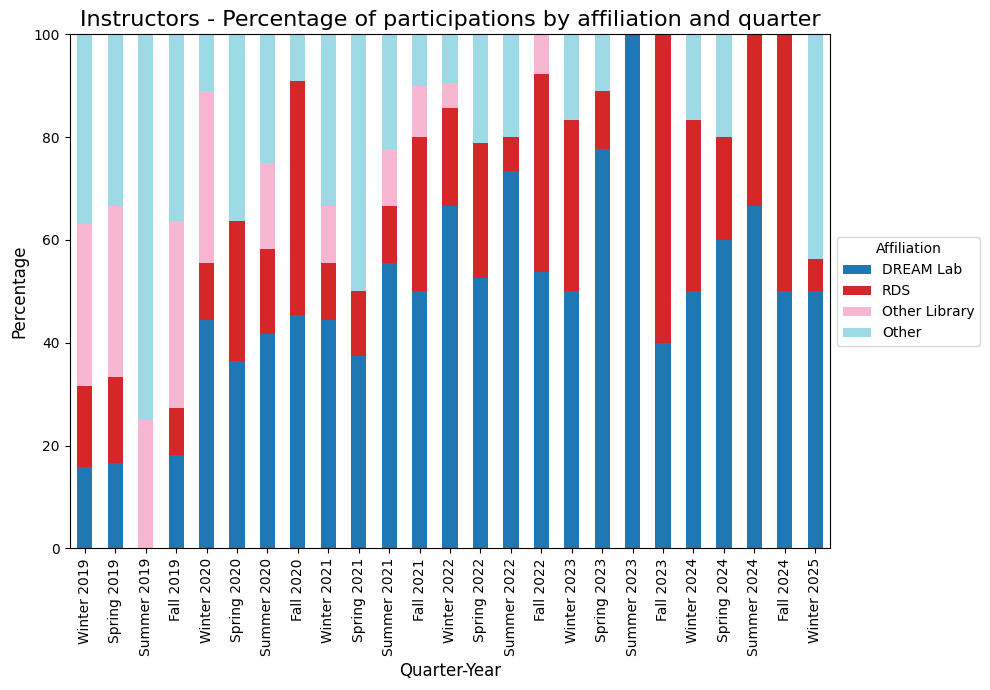

In [34]:
# Convert the counts to percentages (row-wise)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the stacked percentage bar plot
grouped_percent.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')

# Add title, labels, and legend
plt.title('Instructors - Percentage of participations by affiliation and quarter', fontsize=16)
plt.xlabel('Quarter-Year', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Affiliation', loc='center left', bbox_to_anchor=(1, 0.5))

# Ensure the y-axis ranges from 0 to 100%
plt.ylim(0, 100)

# Display the plot
plt.tight_layout()
plt.savefig('plots/int_perc_quarter.png', dpi=300, bbox_inches='tight')
plt.show()

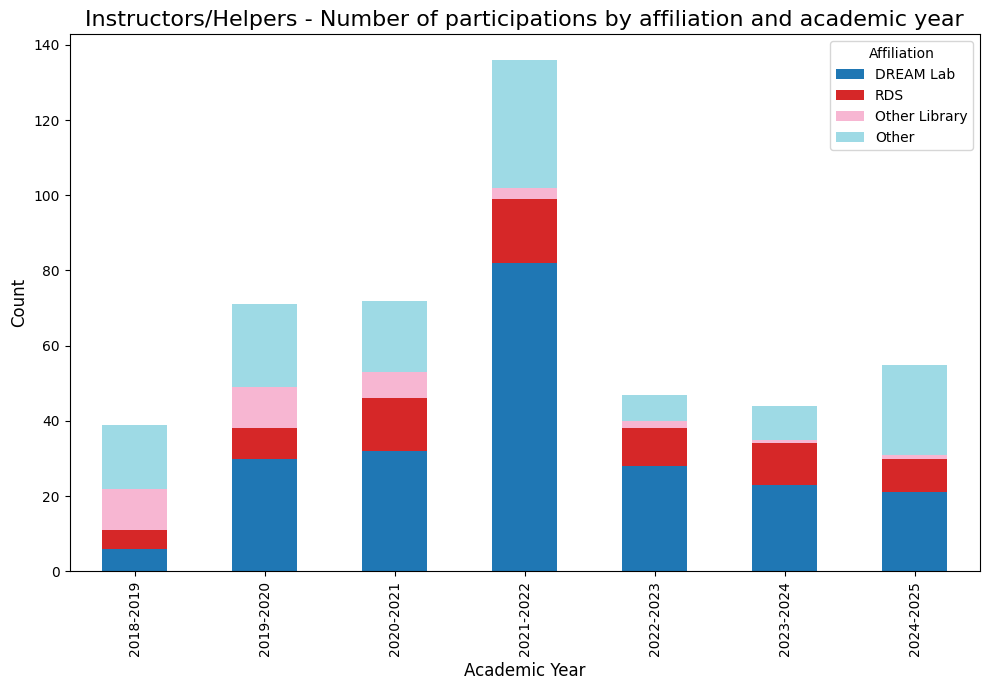

In [35]:
# Group by 'quarter-year' and 'Affiliation' and count occurrences
grouped = df.groupby(['academic-year', 'Affiliation']).size().unstack(fill_value=0)
total = grouped.sum(axis=0)
total.name = 'Total'
grouped = pd.concat([grouped, total.to_frame().T])
# Reorder columns (Affiliation) in the desired order
desired_order = ['DREAM Lab', 'RDS', 'Other Library', 'Other']
grouped = grouped.reindex(columns=desired_order, fill_value=0)

# Plot the stacked bar plot
grouped.drop(index='Total').plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')

# Add title, labels, and legend
plt.title('Instructors/Helpers - Number of participations by affiliation and academic year', fontsize=16)
plt.xlabel('Academic Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Affiliation')

# Display the plot
plt.tight_layout()
plt.savefig('plots/int_help_number_year.png', dpi=300, bbox_inches='tight')
plt.show()

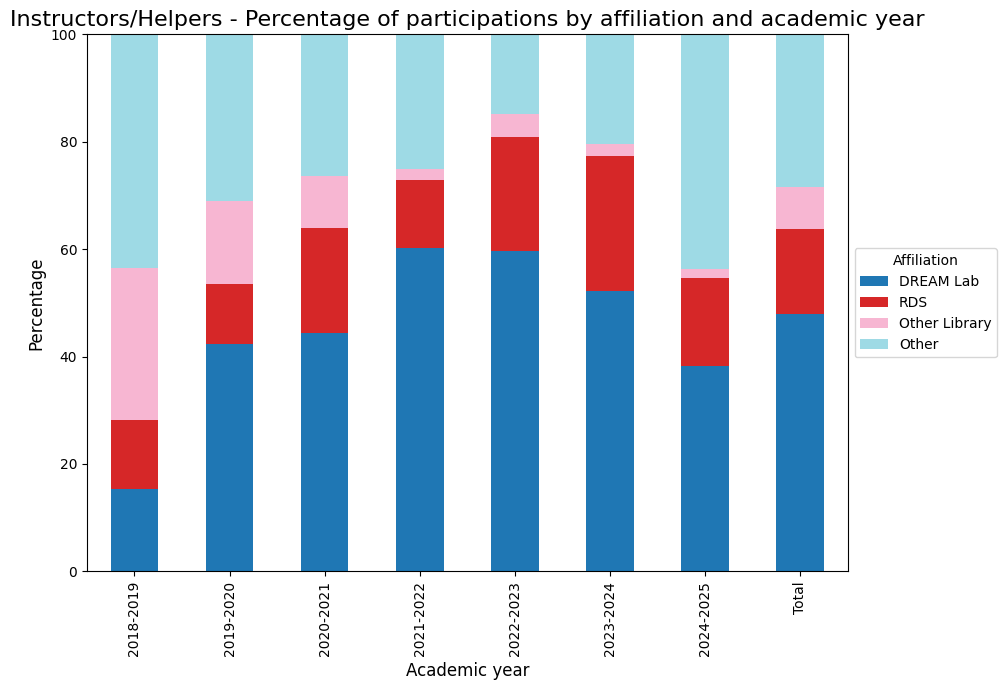

In [36]:
# Convert the counts to percentages (row-wise)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the stacked percentage bar plot
grouped_percent.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')

# Add title, labels, and legend
plt.title('Instructors/Helpers - Percentage of participations by affiliation and academic year', fontsize=16)
plt.xlabel('Academic year', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Affiliation', loc='center left', bbox_to_anchor=(1, 0.5))

# Ensure the y-axis ranges from 0 to 100%
plt.ylim(0, 100)

# Display the plot
plt.tight_layout()
plt.savefig('plots/int_help_perc_year.png', dpi=300, bbox_inches='tight')
plt.show()

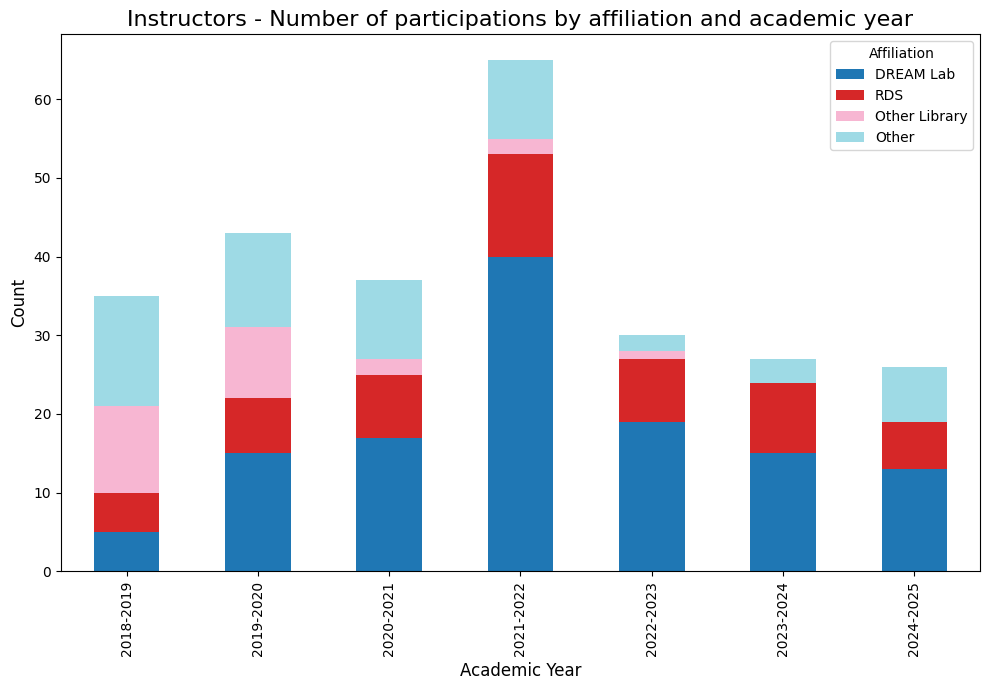

In [37]:
# Group by 'quarter-year' and 'Affiliation' and count occurrences
data = df[df['role'] == 'instructor']
grouped = data.groupby(['academic-year', 'Affiliation']).size().unstack(fill_value=0)
total = grouped.sum(axis=0)
total.name = 'Total'
grouped = pd.concat([grouped, total.to_frame().T])
# Reorder columns (Affiliation) in the desired order
desired_order = ['DREAM Lab', 'RDS', 'Other Library', 'Other']
grouped = grouped.reindex(columns=desired_order, fill_value=0)

# Plot the stacked bar plot
grouped.drop(index='Total').plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')

# Add title, labels, and legend
plt.title('Instructors - Number of participations by affiliation and academic year', fontsize=16)
plt.xlabel('Academic Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Affiliation')

# Display the plot
plt.tight_layout()
plt.savefig('plots/int_number_year.png', dpi=300, bbox_inches='tight')
plt.show()

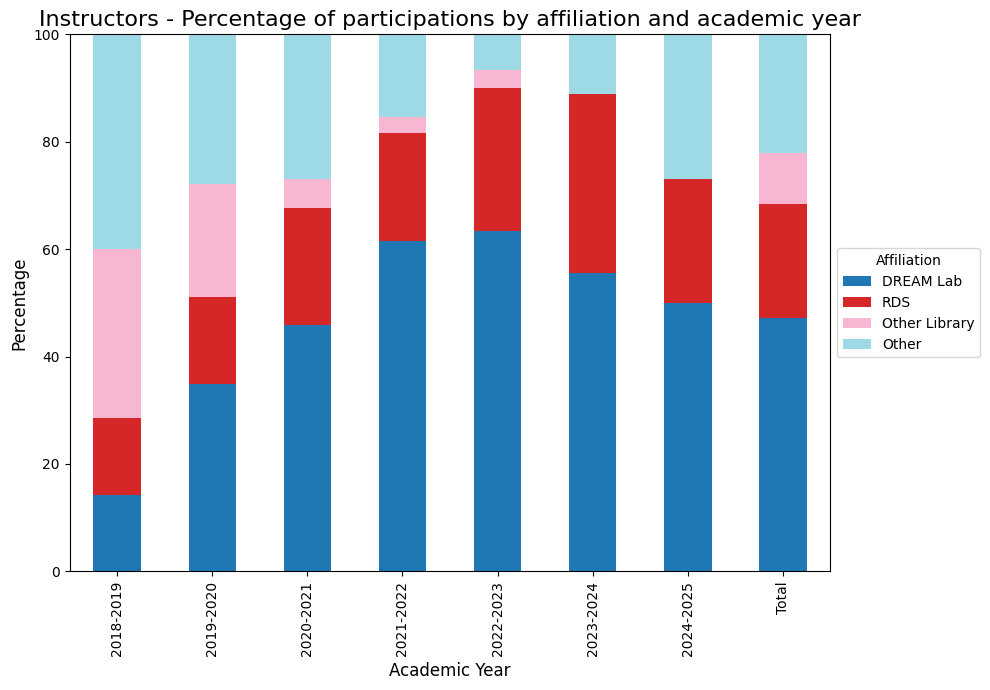

In [38]:
# Convert the counts to percentages (row-wise)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the stacked percentage bar plot
grouped_percent.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')

# Add title, labels, and legend
plt.title('Instructors - Percentage of participations by affiliation and academic year', fontsize=16)
plt.xlabel('Academic Year', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Affiliation', loc='center left', bbox_to_anchor=(1, 0.5))

# Ensure the y-axis ranges from 0 to 100%
plt.ylim(0, 100)

# Display the plot
plt.tight_layout()
plt.savefig('plots/int_perc_year.png', dpi=300, bbox_inches='tight')
plt.show()